# Стоимость медицинского страхования

Данные - https://www.kaggle.com/mirichoi0218/insurance

В датасете представлены данные о жителях США и стоимости их медицинской страховки. Задание: изучить взаимодействия признаков между собой и построить предсказательную модель (целевая переменная - стоимость страховки).

## Загрузка данных

In [410]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
import statsmodels.api as sm
from statsmodels.stats.api import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

In [490]:
data = pd.read_csv('insurance.csv',header=0)
data.head(10)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560
8,37,male,29.830,2,no,northeast,6406.41070
9,60,female,25.840,0,no,northwest,28923.13692


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


В данных отсутствуют пропуски.

Описание признаков:
* age - возраст
* sex - пол
* bmi - индекс массы тела. Вычисляется как (масса в кг)/(рост в метрах)^2
* children - количество детей
* smoker - курит ли человек
* region - регион США (юго-запад, северо-запад, северо-восток, юго-восток)
* charges - стоимость медицинской страховки (целевая переменная)

# Изучение признаков

Построим гистограммы непрерывных признаков, чтобы изучить их распределение.

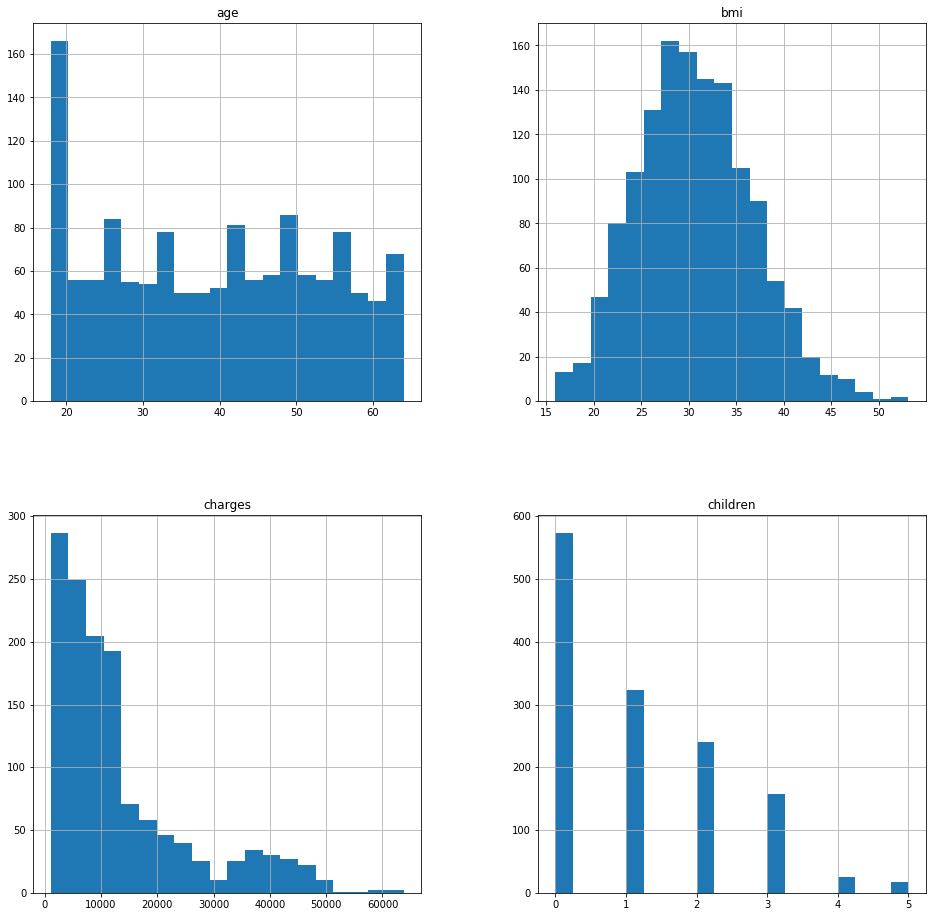

In [5]:
data.hist(figsize=(16,16),bins=20)
plt.show()

Все признаки, кроме индекса массы тела, имеют распределение, явно отличное от нормального. Для их исследования необходимо применять непараметрические критерии. Проверим распределение индекса массы тела на нормальность.

Pvalue for Jarque-Bera:  0.00011618173257721409
Pvalue for Shapiro-Wilk:  2.609841976664029e-05


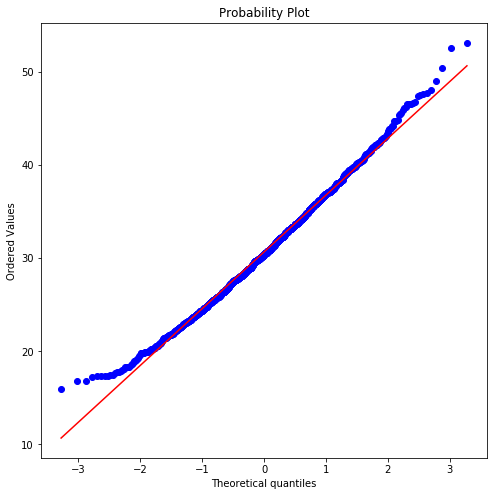

In [6]:
print('Pvalue for Jarque-Bera: ', stats.jarque_bera(data['bmi'])[1])
print("Pvalue for Shapiro-Wilk: ", stats.shapiro(data['bmi'])[1])

plt.figure(figsize=(8,8))
stats.probplot(data['bmi'],dist='norm',plot=plt,fit=True)
plt.show()

Формальные критерии отвергают гипотезу о нормальности, но визуальный анализ указывает на то, что отличаются только хвосты распределения. Подобное являение - общеизвестный факт, поэтому будем считать, что индекс массы тела распределен нормально.

Изучим распределение категориальных признаков.

In [7]:
data.groupby('sex').count()['age']/len(data)

sex
female    0.494768
male      0.505232
Name: age, dtype: float64

In [8]:
data.groupby('region').count()['age']/len(data)

region
northeast    0.242152
northwest    0.242900
southeast    0.272048
southwest    0.242900
Name: age, dtype: float64

In [9]:
data.groupby('smoker').count()['age']/len(data)

smoker
no     0.795217
yes    0.204783
Name: age, dtype: float64

Пол и регион распределены практически равномерно, также в данных больше некурящих людей. Изучим влияние непрерывных признаков на целевую переменную.

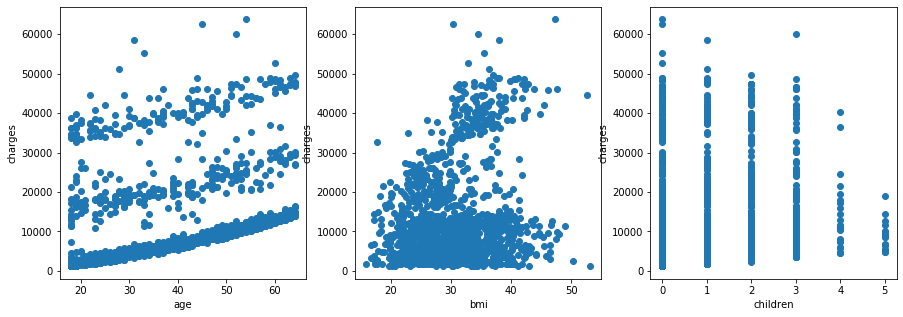

In [10]:
continuous = ['age','bmi','children']
plt.figure(figsize=(15,5))
for i in range(0,3):
    feature = continuous[i]
    plt.subplot(131+i,xlabel=feature,ylabel='charges')
    plt.scatter(data[feature],data['charges'])
plt.show()

Видна ярко выраженная разнородная зависимость: очевидно влияние категориальных переменных. Посмотрим как каждая из них влияет на изменение типа зависимости.

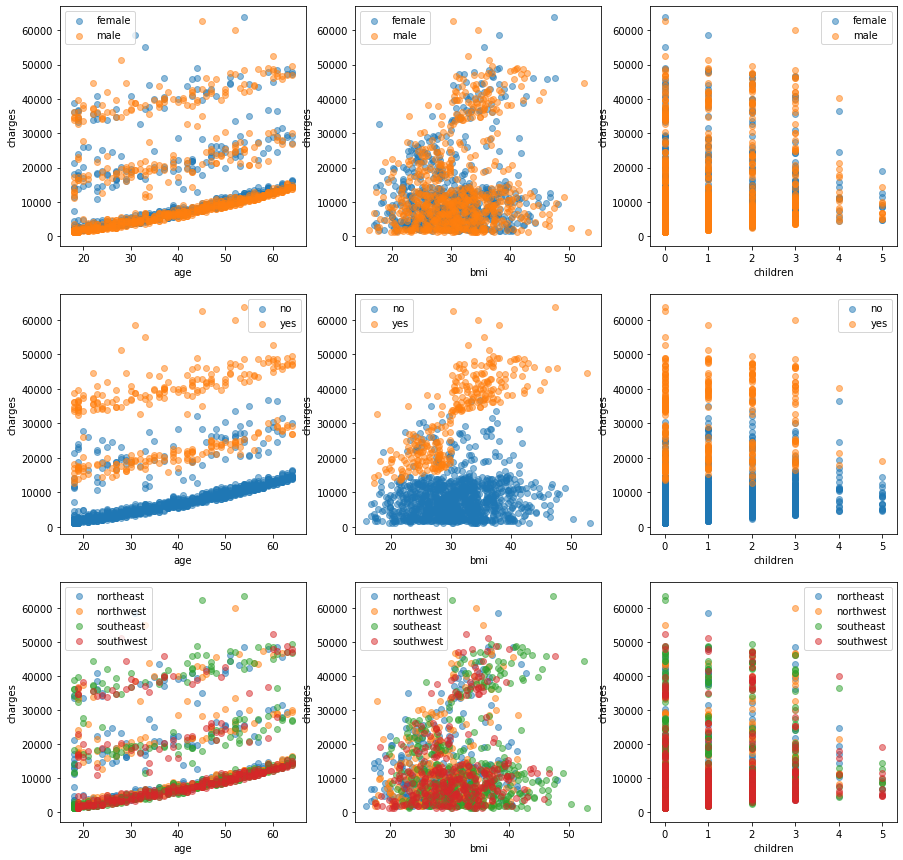

In [11]:
plt.figure(figsize=(15,15))
nominal = ['sex','smoker','region']
for i in range(3):
    groups = data.groupby(nominal[i])
    for j in range(0,3):
        plt.subplot(331 + i*3 + j,xlabel=continuous[j],ylabel='charges')
        for name, group in groups:
            plt.scatter(group[continuous[j]], group['charges'],label=name,alpha=0.5)
        plt.legend()
plt.show()

Пол человека, как видно, не меняет тенденцию зависимости. Курение же, наоборот, не только однозначно влияет на стоимость страховки (для курящих она больше), но и меняет тип зависимости: это видно для индекса массы тела и возраста. Существует ли различие по регионам пока неясно.

Изучим влияние категориальных переменных на целевую более детально.

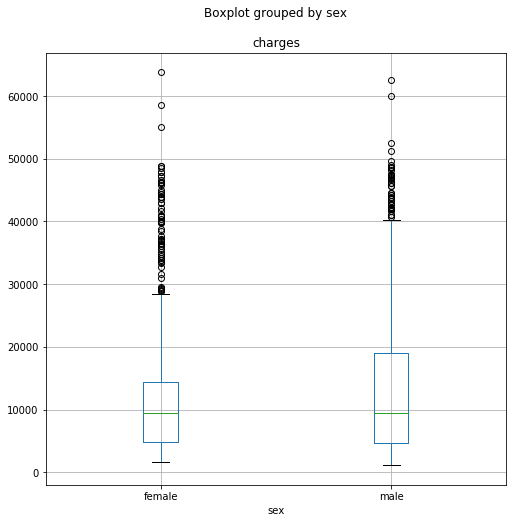

In [13]:
data.boxplot(column='charges',by='sex',figsize=(8,8))
plt.show()

In [25]:
male_charges = data[data.sex=='male']['charges']
female_charges = data[data.sex=='female']['charges']
print('Mean male charges: ', male_charges.mean(), 'Mean female charges: ', female_charges.mean())
print('Median male charges: ', male_charges.median(), 'Median female charges: ', female_charges.median())
print('pvalue for Mann-Whitneyu test: ',stats.mannwhitneyu(male_charges,female_charges)[1])

Mean male charges:  13956.751177721886 Mean female charges:  12569.57884383534
Median male charges:  9369.61575 Median female charges:  9412.9625
pvalue for Mann-Whitneyu test:  0.36432554472350465


Поскольку распределение стоимости услуг не является нормальным, воспользуемся критерием Манна-Уитни. Согласно нему, распределения выборок для разных полов не различаются.

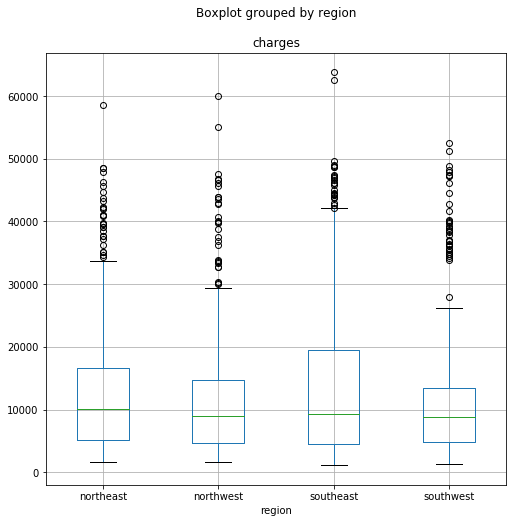

In [26]:
data.boxplot(column='charges',by='region',figsize=(8,8))
plt.show()

In [44]:
sw_charges = data[data.region == 'southwest']['charges']
se_charges = data[data.region == 'southeast']['charges']
ne_charges = data[data.region == 'northeast']['charges']
nw_charges = data[data.region == 'northwest']['charges']
print('Pvalue for Kruskal-Wallis test: ',stats.kruskal(sw_charges, se_charges, ne_charges, nw_charges)[1])

Pvalue for Kruskal-Wallis test:  0.19232908072121002


Регион проживания также не влияет на распределение целевой переменной.

In [47]:
smoker_charges = data[data.smoker == 'yes']['charges']
non_smoker_charges = data[data.smoker == 'no']['charges']
print('pvalue for Mann-Whitneyu test: ',stats.mannwhitneyu(smoker_charges,non_smoker_charges)[1])

pvalue for Mann-Whitneyu test:  2.6351167222517853e-130


Фактор курения, очевидно, влияет. Изучим корреляции непрерывных признаков.

In [52]:
data[continuous].corr(method='spearman')

,age,bmi,children
age,1.000000,0.107736,0.056992
bmi,0.107736,1.000000,0.015607
children,0.056992,0.015607,1.000000


Коэффициенты корреляции крайне малы, поэтому будем считать, что признаки не корреляируют между собой. Посмотрим на корреляцию предикторов с целевой переменной.

In [471]:
data[continuous].corrwith(data.charges, method='spearman')

age         0.534392
bmi         0.119396
children    0.133339
dtype: float64

Коэффициенты отражают зависимость намного слабее той, что была видна на графиках. Это связано с влиянием номинальных признаков на типы зависимостей. Покажем на примере индекса массы тела и курения.

In [60]:
smoker_bwi = data[data.smoker == 'yes']['bmi']
non_smoker_bwi = data[data.smoker == 'no']['bmi']
print ('Correlation coefficient and pvalue for smokers: ',stats.pearsonr(smoker_bwi,smoker_charges))
print ('Correlation coefficient and pvalue for non-smokers: ',stats.pearsonr(non_smoker_bwi,non_smoker_charges))

Correlation coefficient and pvalue for smokers:  (0.8064806070155406, 5.019668631794899e-64)
Correlation coefficient and pvalue for non-smokers:  (0.08403654312833271, 0.006091408541834608)


Коэффициент корреляции между индексом массы тела и соимостью страховки в 10 раз больше для курильщиков, чем для некурящих. Корреляции для некурящих также признается незначимой. Отсюда делаем вывод, что *индекс массы тела влияет на стоимость страховки только для курящих.*

Признак children кажется несбалансированным, поэтому постараемся преобразовать его в категориальный. Разделим его по группам на тех, у кого нет детей, 1-2 ребенка, и 3 и более детей.

In [491]:
data['children_cat'] = data['children'].copy()
data.loc[data.children == 0, 'children_cat'] = 'no children'
data.loc[(data.children > 0) & (data.children < 3), 'children_cat'] = 'one or two'
data.loc[data.children >= 3, 'children_cat'] = 'many children'

In [82]:
data.groupby('children_cat')['age'].count()/len(data)

children_cat
many children    0.149477
no children      0.428999
one or two       0.421525
Name: age, dtype: float64

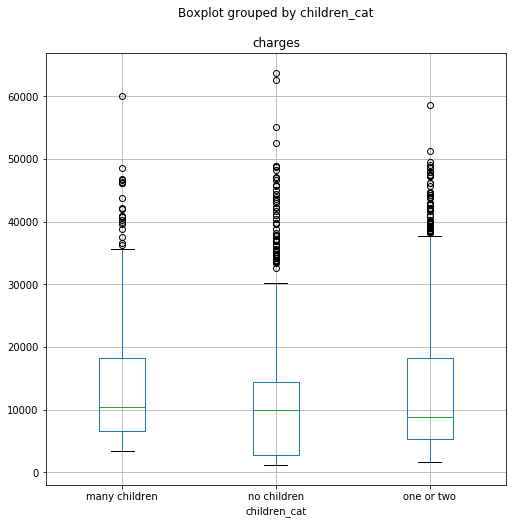

In [83]:
data.boxplot(column='charges',by='children_cat',figsize=(8,8))
plt.show()

In [84]:
mc_charges = data[data.children_cat == 'many children']['charges']
no_charges = data[data.children_cat == 'no children']['charges']
ot_charges = data[data.children_cat == 'one or two']['charges']
print('Pvalue for Kruskal-Wallis test: ',stats.kruskal(mc_charges, no_charges, ot_charges)[1])

Pvalue for Kruskal-Wallis test:  3.989977646255408e-05


Непараметрический тест Краскела-Уоллиса показывает, что распределение целевой переменной меняется в зависимости от уровня нового признака. Таким образом, полученный признак является полезным для анализа. Проверим, сможет ли он объяснить то изменение зависимостей, что было видно на графиках.

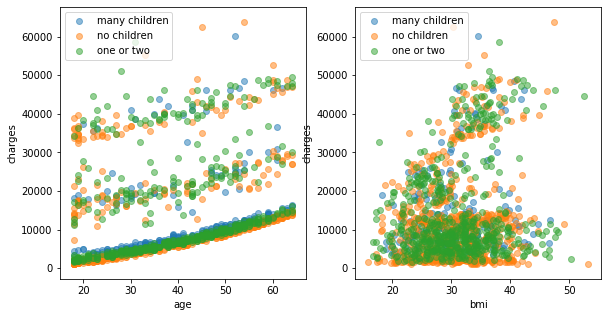

In [88]:
groups = data.groupby('children_cat')
plt.figure(figsize=(15,5))
for i in range(0,2):
    feature = continuous[i]
    plt.subplot(131+i,xlabel=feature,ylabel='charges')
    for name, group in groups:
        plt.scatter(group[feature],group['charges'],label=name,alpha=0.5)
    plt.legend()
plt.show()

Похоже, уровни количества детей не влияют на тип зависимости стоимости страховки от возраста и индекса массы тела. Все первичные взаимодействия переменных рассмотрены, можно переходить к построению модели.

## Построение модели

In [493]:
#X['age'] = data['age'].copy()
data['smoker_bin'] = (data.smoker == 'yes').astype(int)
data['bmi_smoker'] = data['bmi']*data['smoker_bin']
#X['bmi_non'] = data['bmi'] - X['bmi_smoker']

data['no_children'] = (data['children_cat'] == 'no children').astype(int)
data['many_children'] = (data['children_cat'] == 'many children').astype(int)
data.loc[data.no_children == data.many_children , ['many_children','no_children']] = -1

data['male'] = (data.sex == 'male').astype(int)

data['north_west'] = (data.region == 'northwest').astype(int)
data['south_west'] = (data.region == 'southwest').astype(int)
data['north_east'] = (data.region == 'northeast').astype(int)
data.loc[(data.north_west == data.north_east), ['north_west','north_east','south_west']] = -1

#X['south_east'] = (data.region == 'southeast').astype(int)

features = ['age','bmi_smoker','smoker_bin','no_children','many_children','male','north_west','south_west','north_east']
X = sm.add_constant(data[features])

In [494]:
X.head(15)

,const,age,bmi_smoker,smoker_bin,no_children,many_children,male,north_west,south_west,north_east
0,1.0,19,27.90,1,1,0,0,-1,-1,-1
1,1.0,18,0.00,0,-1,-1,1,-1,-1,-1
2,1.0,28,0.00,0,0,1,1,-1,-1,-1
3,1.0,33,0.00,0,1,0,1,1,0,0
4,1.0,32,0.00,0,1,0,1,1,0,0
5,1.0,31,0.00,0,1,0,0,-1,-1,-1
6,1.0,46,0.00,0,-1,-1,0,-1,-1,-1
7,1.0,37,0.00,0,0,1,0,1,0,0
8,1.0,37,0.00,0,-1,-1,1,0,0,1
9,1.0,60,0.00,0,1,0,0,1,0,0


Чтобы было удобнее интерпретировать результаты, разделим целевую переменную на 1000, чтобы стоимость измерялась в тысячах долларов.

In [495]:
y = data['charges'].values/1000

In [496]:
base_model = sm.OLS(y,X).fit()
print(base_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     872.2
Date:                Fri, 24 Jul 2020   Prob (F-statistic):               0.00
Time:                        21:02:05   Log-Likelihood:                -4009.0
No. Observations:                1338   AIC:                             8036.
Df Residuals:                    1329   BIC:                             8083.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -1.2396      0.402     -3.086

Базовая модель, в которую вошли все признаки, указывает на сильную мультиколлинеарность. Из-за этого коэффициенты модели являются далекими от истины - например, согласно модели, для курящих страховка в среднем на 21 тысячу дешевле. Оставим только те признаки, что посчитали важными в первичном анализе.

In [499]:
features_1 = ['age','bmi_smoker','no_children','many_children']
X1 = sm.add_constant(data[features_1])

model1 = sm.OLS(y,X1).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                     1468.
Date:                Fri, 24 Jul 2020   Prob (F-statistic):               0.00
Time:                        21:03:48   Log-Likelihood:                -4106.3
No. Observations:                1338   AIC:                             8223.
Df Residuals:                    1333   BIC:                             8249.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -2.2136      0.440     -5.030

Параметры модели уже поддаются однозначной интерпретации, однако необходимо проверить условия метода наименьших квадратов, которым обучалась модель.

In [500]:
data['resid1'] = model1.resid

#### Линейность отклика

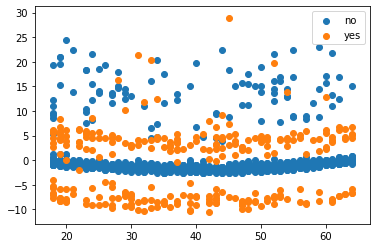

In [505]:
for name, group in data.groupby('smoker'):
    plt.scatter(group['age'],group.resid1,label=name)
plt.legend()
plt.show()

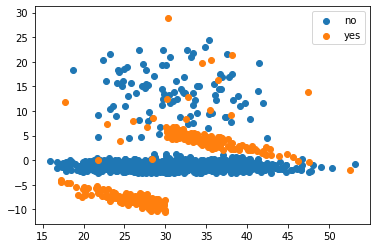

In [506]:
for name, group in data.groupby('smoker'):
    plt.scatter(group['bmi'],group.resid1,label=name)
plt.legend()
plt.show()

Видно, что в модели учтена далеко не вся структура зависимостей.

#### Полнота ранга

In [511]:
for i in range(len(features_1)):
    print(features_1[i],vif(X1.values,i+1))

age 1.003476667189874
bmi_smoker 1.0005008469775931
no_children 1.7428708338006873
many_children 1.7410270285656866


Фактор инфляции дисперсии показывает, что в матрице признаков отсутствует мультиколлинеарность.

#### Случайность ошибки

In [512]:
print('pvalue for ttest: ',stats.ttest_1samp(data.resid1,0)[1])

pvalue for ttest:  0.9999999999999798


Средняя ошибка явно равна нулю.

#### Гомоскедастичность ошибки

In [514]:
print('pvalue for Breusch-Pagan test: ',het_breuschpagan(data.resid1,X1)[1])

pvalue for Breusch-Pagan test:  6.746628120756531e-06


Дисперсия ошибки неоднородна, что еще раз подтверждает то, что модель учитывает не всю структутру зависимостей. Поскольку выполняются не все условия, нельзя сказать, что параметры данной модели оптимальны. На графике остатков от индекса массы тела было видно, что зависимость различается по разные стороны от значения в 30. Простой логикой можно предположить, что люди, чей индекс массы тела превышает 30, страдают лишним весом, и потому для них другие правила определения стоимости страховки. Создадим новые признаки, чтобы учесть этот фактор.

In [588]:
data['overweight'] = (data['bmi'] > 30).astype(int)
data['bmi_smoker_overweight'] = data['bmi']*data['overweight']*data['smoker_bin']
data['bmi_smoker_non_overweight'] = data['bmi']*data['smoker_bin'] - data['bmi_smoker_overweight']
data['smoker_overweight'] = data['overweight']*data['smoker_bin']*2 - 1

features_2 = ['age','no_children','many_children','bmi_smoker_overweight','bmi_smoker_non_overweight','smoker_overweight']
X2 = sm.add_constant(data[features_2])

In [589]:
model2 = sm.OLS(y,X2).fit()
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.866
Method:                 Least Squares   F-statistic:                     1441.
Date:                Fri, 24 Jul 2020   Prob (F-statistic):               0.00
Time:                        21:50:02   Log-Likelihood:                -3887.3
No. Observations:                1338   AIC:                             7789.
Df Residuals:                    1331   BIC:                             7825.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

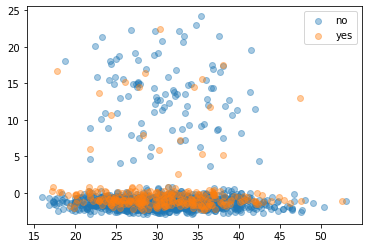

In [590]:
data['resid2'] = model2.resid

for name, group in data.groupby('smoker'):
    plt.scatter(group['bmi'],group.resid2,label=name,alpha=0.4)
plt.legend()
plt.show()

Практически вся зависимость стоимости страховки от индекса массы тела была учтена

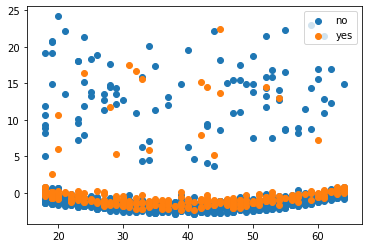

In [582]:
for name, group in data.groupby('smoker'):
    plt.scatter(group['age'],group.resid2,label=name)
plt.legend()
plt.show()

Есть небольшая квадратичная зависимость от возраста, однако если добавить новый признак в виде квадрата возраста, коэффициент при нем и при обычно возрасте будет очень сложно интерпретировать

In [583]:
het_breuschpagan(data.resid2,X2)[1]

0.09860127608020956

Остатки модели гомоскедастичны

In [584]:
for i in range(len(features_2)):
    print(features_2[i],vif(X2.values,i+1))

age 1.0040295350600923
no_children 1.7442711519940635
many_children 1.7427269415308064
bmi_smoker_overweight 65.99627749949823
bmi_smoker_non_overweight 1.014645186478092
smoker_overweight 65.99676773489047


Имеется довольно сильная корреляция между признаками bmi_smoker_weight и smoker_overweight, однако, если убрать один из них, то потеряется структура зависимости между bmi и целевой переменной.

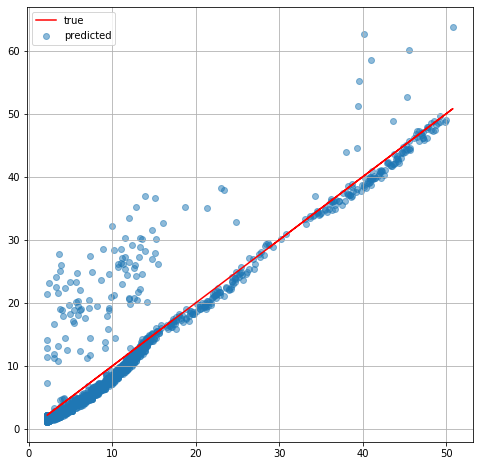

In [577]:
plt.figure(figsize=(8,8))
plt.scatter(model2.fittedvalues,y,alpha=0.5,label='predicted')
plt.plot(model2.fittedvalues,model2.fittedvalues,label='true',color='r')
plt.grid()
plt.legend()
plt.show()

В целом полученная модель получилась достаточно хорошей, поэтому можно переходить к построеню выводов.

## Выводы

- С каждым годом стоимость медицинской страховки человека растет примерно на \\$250;
- Отсутствие детей снижает стоимость страховки примерно на \\$770 относительно среднего, в то время как наличие более трех детей повышает примерно на \\$710;
- Стоимость страховки для курильщиков, страдающих лишним весом, в среднем выше среднего на \\$8000;
- Более конкретно: курильщики, страдающие лишним весом, платят на \\$480 больше за 1 единицу индекса массы тела, не страдающие лишним весом - на \\$520 больше.